In [30]:
struct Global
    nv          ::Int    #boundary point
    jx          ::Int    #cell number
    inter       ::Int #split point of two material
    kindProblem ::Int #kind of problem
    tt          ::Float64      #total time
    cfl         ::Float64     # cfl
end

struct Const
    Y0 ::Float64
    ρ0 ::Float64
    Γ0 ::Float64
    μ  ::Float64
    a0 ::Float64
    s0 ::Float64
end

struct BoundCon
    ρ ::Float64
    u ::Float64
    p ::Float64
    sxx::Float64
end


In [31]:
#module Initial
#export state1, problem1

    

function initial()
    

    nv = 3
    jx = 800
    tt = 1.5e-4
    cfl = 0.5
    lx =1.0
    inter=0
    kindProblem=1
    dx=lx/jx


    ρ2=8930
    u2=0.0
    p2=1.e5
    sxx2=0
    
    
    ρ1=8930
    u1=10.0
    p1=1.e5
    sxx1=0.0
    global    rB=BoundCon(ρ2,u2,p2,sxx2)
    global    lB=BoundCon(ρ1,u1,p1,sxx1)
    
    global   con = Const(9e7,8930,2.0,4.5e10,3940.0,1.49)
    #state1=copper

    u  = zeros(Float64, (jx+2nv+1,4))
    uo = zeros(Float64, (jx+2nv+1,4))

    x = [(i+0.5-nv-1)*dx for i=1:jx+2nv+1]

    for i=1:jx+2nv+1 
        uo[i,1] = ρ1
        uo[i,2] = u2
        uo[i,3] = p1
        uo[i,4] = sxx1
        u[i,:]=UoTou(uo[i,:],con)
    end    

    global   problem=Global(nv,jx,inter,kindProblem, tt,cfl)
    return uo,u,x
end

#PyPlot.plot(x,uo[:,1:4])
#end

initial (generic function with 1 method)

$$ 1Pa = 1N/m^2 = 1 kg/(m\cdot s^2) = 10^{-11} g/(cm \cdot \mu s^2)$$ 

$$ 1 m/s = 10^{-4} cm/\mu s$$
$$ 1kg/m^3 = 10^{-3} g/cm^3$$


$$f(\eta) = \frac{(\eta-1)(\eta-\Gamma_0(\eta-1)/2)}{(\eta-s_0(\eta-1))^2}$$
$$f'(\eta) = \frac{\eta+(s_0-\Gamma_0)(\eta-1)}{(\eta-s_0(\eta-1))^3}$$

In [32]:

function fη(ρ::Float64,c::Const=con)
    η = ρ/c.ρ0
    fη=(η-1.0)*(η-c.Γ0*(η-1.0)/2.0)/(η-c.s0*(η-1))^2
end

function fηη(ρ::Float64,c::Const)
    η = ρ/c.ρ0
    fηη=(η+(c.s0-c.Γ0)*(η-1))/(η-c.s0*(η-1))^3
end


fηη (generic function with 1 method)

Mie-Gr\"uneisen equation of state
$$e =\frac{p-\rho_0a_0^2f(\eta)}{\rho_0\Gamma_0}$$

$$p = \rho_0a_0^2f(\eta)+\rho_0\Gamma_0e$$

In [33]:
function PToe(ρ::Float64,p::Float64,con::Const)
    c=con
    ei = (p-c.ρ0*c.a0^2*fη(ρ,c))/(c.ρ0*c.Γ0)
    return ei
end
function EToP(ρ::Float64,ei::Float64,con::Const)
    c=con
    p = c.ρ0*c.Γ0*ei+c.ρ0*c.a0^2*fη(ρ,c)
    return p
end

EToP (generic function with 1 method)

$$ \begin{aligned}
    & \rho = uo[1]\\
    & u  = uo[2]\\
    & p =uo[3]\\
    & s_{xx}=uo[4]
     \end{aligned} \hspace{0.3cm}
    \begin{aligned}
    &U[1]=\rho\\
    &U[2]=\rho u\\
    &U[3]=\rho E\\
    &U[4]=s_{xx}\\
    \end{aligned}
$$

$$ e=E/\rho-\frac{1}{2}u^2$$


In [34]:
"""
 from  the primitive variables uo to  conservative variables U
"""
function UoTou(uo::Array{Float64,1},con::Const)
    u = zeros(Float64, 4)
    u[1]=uo[1]
    u[2]=uo[2]*uo[1]
    ei = PToe(uo[1],uo[3],con)
    u[3]=(ei+0.5uo[2]^2)*uo[1]
    u[4]=uo[4]
    return u
end

UoTou

In [35]:
"""
 from conservative variables U  to  the primitive variables uo
"""
function UToUo(u::Array{Float64,1},con::Const)
    uo = zeros(Float64, 4)
    uo[1]=u[1]
    uo[2]=u[2]/u[1]
    ei=u[3]/uo[1]-0.5uo[2]^2
    p = EToP(uo[1],ei,con)
    uo[3]=p
    uo[4]=u[4]
    return uo
end  

UToUo

$$ c=\sqrt{a^2-\frac{\rho_0}{\rho^2}\Gamma_0s_{xx}+\frac{4}{3}\frac{\mu}{\rho}}$$
$$ a^2= a_0^2 f'(\eta)+\frac{p}{\rho^2}\rho_0\Gamma_0$$

In [36]:
function sound(uo::Array{Float64,1},con::Const=con)::Float64
    a0  = con.a0
    ρ0  = con.ρ0
    Γ0  = con.Γ0
    μ   = con.μ
    ρ   = uo[1]
    uu  = uo[2]
    p   = uo[3]
    sxx = uo[4]
    a2  = a0^2*fηη(ρ,con)+p/ρ^2*ρ0*Γ0
    c=sqrt(a2-ρ0/ρ^2*Γ0*sxx+4.0/3*μ/ρ)
    return c
end


function Cfl(uo::Array{Float64,2},x::Array{Float64,1},problem::Global=problem,con::Const=con)
    nv=problem.nv
    jx=problem.jx
    sf=problem.cfl
    
    dx1=0
    dxmin=x[nv+2]-x[nv+1]
    for i in nv+2:jx+nv+1
        dx  = x[i]-x[i-1]
        c = sound(uo[i,:],con)
        dxmin = min(dx,dxmin)
        dx1=dxmin/c
    end
    dt=sf*dx1
    return dt
end    


Cfl (generic function with 3 methods)

In [58]:
function Wilkins()
    
    nv = 3
    jx = 800
    tt = 5.e-6
    cfl = 0.5
    lx =5.e-2
    inter=0
    kindProblem=2
    dx=lx/jx


    ρ2=2785
    u2=0.0
    p2=1.e-6
    sxx2=0
    
    
    ρ1=2785
    u1=800.0
    p1=1.e-6
    sxx1=0.0
    global    rB=BoundCon(ρ2,u2,p2,sxx2)
    global    lB=BoundCon(ρ1,u1,p1,sxx1)
    
    #global   con = Const(9e7,8930,2.0,4.5e10,3940.0,1.49)  #copper
    
    global   con = Const(3e8,2785,2.0,2.76e10,5328.0,1.338)  #

    u  = zeros(Float64, (jx+2nv+1,4))
    uo = zeros(Float64, (jx+2nv+1,4))

    x = [(i+0.5-nv-1)*dx for i=1:jx+2nv+1]

    for i=1:jx+2nv+1
        if x[i] < 5.e-3 
            uo[i,1] = ρ1
            uo[i,2] = u1
            uo[i,3] = p1
            uo[i,4] = sxx1
            u[i,:]=UoTou(uo[i,:],con)
        else
            uo[i,1] = ρ2
            uo[i,2] = u2
            uo[i,3] = p2
            uo[i,4] = sxx2
            u[i,:]=UoTou(uo[i,:],con)
        end
    end

    global   problem=Global(nv,jx,inter,kindProblem, tt,cfl)
    return uo,u,x
end

Wilkins (generic function with 1 method)

In [41]:
function WENO3(u::Array{Float64,1})
    ε = 1.e-10
    I, = size(u)
    uL = zeros(Float64,I)
    uR = zeros(Float64,I)
    for i in 2:I-1
        IS0 = (u[i] - u[i-1])^2
        IS1 = (u[i+1] - u[i])^2
        
        c0 = 2/3
        c1 = 1/3
        
        α0 = c0/(ε + IS0)
        α1 = c1/(ε + IS1)
        
        β0 = α0/(α0+α1)
        β1 = α1/(α0+α1)
        
        uR[i-1] = β0*(u[i]+u[i-1])/2+β1*(3u[i]-u[i+1])/2
        
        c0 = 1/3
        c1 = 2/3
        
        α0 = c0/(ε + IS0)
        α1 = c1/(ε + IS1)
        
        β0 = α0/(α0+α1)
        β1 = α1/(α0+α1)
        
        uL[i] = β0*(3u[i]-u[i-1])/2+β1*(u[i]+u[i+1])/2
    end
    return uL,uR
end
        

WENO3 (generic function with 1 method)

In [42]:
function Upwind(u::Array{Float64,1})
     I, = size(u)
    uL = zeros(Float64,I)
    uR = zeros(Float64,I)
    for i in 2:I-1
        uL[i] = u[i]
        uR[i] = u[i+1]
    end
    return uL,uR
end


Upwind (generic function with 1 method)

In [43]:
function Yυ(s::Float64,con::Const=con)
    Y0 = con.Y0
    f=0
    if abs(s) <= 2Y0/3
        f = s
    elseif s > 2Y0/3
        f = 2Y0/3
    else
        f = -2Y0/3
    end
end

Yυ (generic function with 2 methods)

In [44]:
function HLLCEPNew(u::Array{Float64,1},uL::Array{Float64,2},uR::Array{Float64,2},
        problem::Global=problem,con::Const=con)
    Y0 = con.Y0
    ρ0 = con.ρ0
    Γ0 = con.Γ0
    nv = problem.nv
    jx = problem.nv
    μ  = con.μ
    I,J = size(uL)
    f  = zeros(Float64,(I,J))
    uuh = zeros(Float64,I)
    
    for i in 1+nv:I-nv
        ρL =  uL[i,1]
        uuL = uL[i,2]
        pL  = uL[i,3]
        sxxL= uL[i,4]
        σL  = -pL+sxxL
        cL = sound(uL[i,:])
        eL = PToe(ρL, pL, con)
        
        ρR =  uR[i,1]
        uuR = uR[i,2]
        pR  = uR[i,3]
        sxxR= uR[i,4]
        σR  = -pR+sxxR
        cR = sound(uR[i,:])
        eR = PToe(ρR, pR, con)
        
        sL = min(uuL-cL, uuR-cR)
        sR = max(uuL+cL, uuR+cR)
        
        s_star = (σL - σR + ρL*uuL*(sL-uuL) - ρR* uuR*(sR-uuR))/(ρL*(sL-uuL)-ρR*(sR-uuR))
        
        ρLstar = ρL*(uuL-sL)/(s_star - sL)
        ρRstar = ρR*(uuR-sR)/(s_star - sR)
        
        tmp = -4.0μ/3*log(ρLstar/ρL) +sxxL
        #if (abs(sxxL) < 2Y0/3 && abs(tmp) >= 2Y0/3)
        if abs(tmp) >= 2Y0/3 
            if tmp > 2Y0/3
                hsxxL = 2Y0/3
                hρL  = ρL*exp(-Y0/(2μ)+3sxxL/(4μ))
            elseif tmp < -2/3*Y0
                hsxxL = -2Y0/3
                hρL  = ρL*exp(Y0/(2μ)+3sxxL/(4μ))
            end
            t    = ρL*hρL/(hρL-ρL)
            c0   = 1/(ρ0*Γ0)
            c1   = a0^2/Γ0
            hpL   = (2t*(c1*fη(hρL,con)+eL)-(σL+hsxxL))/(2t*c0-1)
            hσL = -hpL + hsxxL
            if ρLstar > ρL
               huuL = uuL -sqrt((σL-hσL)/t)
            else
               huuL = uuL +sqrt((σL-hσL)/t)
            end
            ρL   = hρL
            uuL  = huuL
            pL   = hpL
            sxxL = hsxxL
            σL   = hσL
            ue[1] = ρL
            ue[2] = uuL
            ue[3] = pL
            ue[4] = sxxL
            cL = sound(ue,con)
        end
        
        tmp = -4.0μ/3*log(ρRstar/ρR) +sxxR
        #if (abs(sxxR) < 2Y0/3 && abs(tmp) >= 2Y0/3) 
        if abs(tmp) >= 2Y0/3
            if tmp > 2Y0/3
               hsxxR = 2Y0/3
               hρR  = ρR*exp(-Y0/(2μ)+3sxxR/(4μ))
            elseif tmp < -2/3*Y0
               hsxxR = -2Y0/3
               hρR  = ρR*exp(Y0/(2μ)+3sxxR/(4μ))
            end
            t    = ρR*hρR/(hρR-ρR)
            c0   = 1/(ρ0*Γ0)
            c1   = a0^2/Γ0
           hpR   = (2t*(c1*fη(hρR,con)+eR)-(σR+hsxxR))/(2t*c0-1)
           hσR = hpR +hsxxR
            if ρRstar > ρR
               huuR = uuR +sqrt((σR-hσR)/t)
            else
               huuR = uuR -sqrt((σR-hσR)/t)
            end
            ρR = hρR
            uuR = huuR
            pR = hpR
            sxxR = hsxxR
            σR = hσR
            ue[1] = ρR
            ue[2] = uuR
            ue[3] = pR
            ue[4] = sxxR
            cR = sound(ue,con)
        end
        sL = min(uuL-cL,uuR-cR)
        sR = max(uuL+cL,uuR+cR)
        
        s_star = (σL - σR + ρL*uuL*(sL-uuL) - ρR* uuR*(sR-uuR))/(ρL*(sL-uuL)-ρR*(sR-uuR))
        
        ρLstar = ρL*(uuL-sL)/(s_star - sL)
        ρRstar = ρR*(uuR-sR)/(s_star - sR)
        
        tmp = -4μ/3*log(ρLstar/ρL) +sxxL
        if tmp >= 2Y0/3
            sxxLstar = 2Y0/3
        elseif tmp <= -2Y0/3
            sxxLstar  = -2Y0/3
        else
            sxxLstar = tmp
        end
        
        tmp = -4μ/3*log(ρRstar/ρR) +sxxR
        
        if tmp >= 2Y0/3
            sxxRstar = 2Y0/3
        elseif tmp <= -2Y0/3
            sxxRstar  = -2Y0/3
        else
            sxxRstar = tmp
        end
        
        σstar = σL-ρL*(sL-uuL)*(s_star-uuL)
        pLstar = sxxLstar-σstar
        pRstar = sxxRstar-σstar
        
        if s_star > u[i] 
            f[i,1] = 0
            f[i,2] = pLstar-sxxLstar
            f[i,3] = (pLstar-sxxLstar)*s_star
            f[i,4] = -4μ/3*s_star
            uuh[i] = s_star
        else
            f[i,1] = 0
            f[i,2] = pRstar-sxxRstar
            f[i,3] = (pRstar-sxxRstar)*s_star
            f[i,4] = -4μ/3*s_star
            uuh[i] = s_star
        end
    end
    return f, uuh
end

HLLCEPNew (generic function with 3 methods)

In [45]:
function HLLCEP(u::Array{Float64,1},uL::Array{Float64,2},uR::Array{Float64,2},
        problem::Global=problem,con::Const=con)
    Y0 = con.Y0
    ρ0 = con.ρ0
    Γ0 = con.Γ0
    μ  = con.μ
    nv = problem.nv
    jx = problem.jx
    I,J = size(uL)
    f  = zeros(Float64,(I,J))
    uuh = zeros(Float64,I)
    
    for i in 1:I
        ρL =  uL[i,1]
        uuL = uL[i,2]
        pL  = uL[i,3]
        sxxL= uL[i,4]
        σL  = -pL+sxxL
        cL = sound(uL[i,:])
        eL = PToe(ρL, pL, con)
        
        ρR =  uR[i,1]
        uuR = uR[i,2]
        pR  = uR[i,3]
        sxxR= uR[i,4]
        σR  = -pR+sxxR
        cR = sound(uR[i,:])
        eR = PToe(ρR, pR, con)
        
        sL = min(uuL-cL, uuR-cR)
        sR = max(uuL+cL, uuR+cR)
        s_barstar = (sxxR-sxxL)/(ρL*(sL-uuL)-ρR*(sR-uuR))
        sxxL_bar = sxxL+ρL*(sL-uuL)*s_barstar
        sxxR_bar = sxxR+ρR*(sR-uuR)*s_barstar
        
        sxxL_star = Yυ(sxxL_bar)
        sxxR_star = Yυ(sxxR_bar)
        
        sxL_star = (sxxL_star-sxxL)/(ρL*(sL-uuL))
        sxR_star = (sxxR_star-sxxR)/(ρR*(sR-uuR))
        
        
        s_star = (pR - pL + ρL*(uuL-sxL_star)*(sL-uuL) - ρR* (uuR-sxR_star)*(sR-uuR))/(ρL*(sL-uuL)-ρR*(sR-uuR))
        
        pL_star = pL+ρL*(sL-uuL)*(s_star + sxL_star - uuL)
        pR_star = pR+ρR*(sR-uuR)*(s_star + sxR_star - uuR)
        
        if s_star > u[i]
            f[i,1] = 0
            f[i,2] = pL_star-sxxL_star
            f[i,3] = (pL_star-sxxL_star)*s_star
            f[i,4] = -4μ/3*s_star 
            uuh[i] = s_star
        else
            f[i,1] = 0
            f[i,2] = pR_star-sxxR_star
            f[i,3] = (pR_star-sxxR_star)*s_star
            f[i,4] = -4μ/3*s_star 
            uuh[i] = s_star
        end
    end
    return f, uuh
end
        

HLLCEP (generic function with 3 methods)

In [76]:
function Space(uo::Array{Float64,2},problem::Global=problem,con::Const=con)
    kind_split = 1
    nv = problem.nv
    h = zeros(Float64,2)
   
    I,J = size(uo)
    uL=zeros(Float64,(I,J))
    uR=zeros(Float64,(I,J))
    f=zeros(Float64,(I,J))
    uuh=zeros(Float64,I)
     if kind_split==1
        for i in 1:J
            uL[:,i],uR[:,i] = WENO3(uo[:,i])
            #uL[:,i],uR[:,i] = Upwind(uo[:,i])
        end
        h,uuh = HLLCEP(uo[:,2],uL,uR)
     end
    for i in 2:I-1
        f[i,:]= h[i,:]-h[i-1,:]
    end
    return f,uuh
end
        

Space (generic function with 3 methods)

In [61]:
function Bound!(uo::Array{Float64,2},u::Array{Float64,2},lB::BoundCon=lB,rB::BoundCon=rB,problem::Global=problem)
    kind_prb= problem.kindProblem
    nv = problem.nv
    jx = problem.jx
    ρ0 = con.ρ0
    uu = lB.u
    ρ  = lB.ρ
    
    if kind_prb == 1
        for i in 1:nv
            uo[i,:] = uo[nv+1,:]
            uo[i,2] = uu
            u[i,:] = u[nv+1,:]
            u[i,2] = u[i,1]*uu
            
            uo[i+jx+nv+1,:] = uo[jx+nv+1-i,:]
            uo[i+jx+nv+1,2] = -uo[jx+nv+1-i,2]
            
            u[i+jx+nv+1,:]=u[jx+nv+1-i,:]
            u[i+jx+nv+1,2]=-u[jx+nv+1-i,2]
        end
    elseif kind_prb == 2
        ue = zeros(Float64,4)
        for i in 1:nv
            uo[i,1] = ρ
            uo[i,2] = uo[nv+1,2]
            uo[i,3] = 0
            uo[i,4] = 0
            
            ue[1] = ρ
            ue[2] = u[nv+1,2]/ρ
            ue[3] = 0
            ue[4] = 0
            
            u[i,:] = UoTou(ue,con)
            
            uo[i+jx+nv+1,:] = uo[jx+nv+1-i,:]
            
            u[i+jx+nv+1,:] = u[jx+nv+1-i,:]
        end  
    end
    return uo,u
end

Bound! (generic function with 4 methods)

In [62]:
#function R_K(dt::Float64,uo::Array{Float64,2},x::Array{Float64,1},lB::BoundCon=lB,rB::BoundCon=rB,problem::Global=problem,con::Const=con,order::Int8=3)
#    if order==3
#       uo,x = R_K3(dt,uo,x)
#    end
#    return uo,x
#end
function R_K3(dt::Float64,uo::Array{Float64,2},x::Array{Float64,1},
        lB::BoundCon=lB,rB::BoundCon=rB,problem::Global=problem,con::Const=con)
    μ = con.μ
    I,J=size(uo)
    dx = zeros(Float64,I)
    udx= zeros(Float64,(I,J))
    u= zeros(Float64,(I,J))
    for i in 2:I
        dx[i] =x[i]-x[i-1]
    end
    dx[1] =dx[2]
    
    for i in 1:I    
        u[i,1:4]=UoTou(uo[i,1:4],con)
        udx[i,1:3]=u[i,1:3]*dx[i]
        udx[i,4] =u[i,4]
    end 
    
    uo,u = Bound!(uo,u)
#****************1**********************    
    f,uuh=Space(uo)   
    #x1 = zeros(Float64,I) 
    
    udx1 = zeros(Float64,(I,J))
    x1   = zeros(Float64,I)
    for i in 1:I
        x1[i] = x[i] + dt*uuh[i]
        udx1[i,4] = udx[i,4] -dt*f[i,4]/dx[i]
    end
    
    for i in 2:I
        dx[i] =x1[i]-x1[i-1]
    end
    dx[1] =dx[2]
    for i in 1:I
        ρ1 = u[i,1]
        udx1[i,1:3] = udx[i,1:3] -dt*f[i,1:3]
        u[i,1:3] = udx1[i,1:3]/dx[i]
        u[i,4]=  udx1[i,4]
        u[i,4]= Yυ(u[i,4])
        uo[i,:] = UToUo(u[i,:],con)
    end
    
    uo,u = Bound!(uo,u)
# #***************2***********************    
    
    f,uuh = Space(uo)
    
    udx2 = zeros(Float64,(I,J))
    x2   = zeros(Float64,I)
   
    for i in 1:I
        x2[i] = 3/4*x[i] +1/4*x1[i]+1/4*dt*uuh[i]
        udx2[i,4] = 3/4*udx[i,4]+1/4*udx1[i,4] -1/4*dt*f[i,4]/dx[i]
    end
   
    for i in 2:I
        dx[i] =x2[i]-x2[i-1]
    end
    dx[1] =dx[2]
    
    for i in 1:I
        udx2[i,1:3] = 3/4*udx[i,1:3]+1/4*udx1[i,1:3] -1/4*dt*f[i,1:3]
        u[i,1:3] = udx2[i,1:3]/dx[i]
        u[i,4]   = udx2[i,4]
        u[i,4]= Yυ(u[i,4])
        uo[i,:] = UToUo(u[i,:],con)
    end    
    uo,u = Bound!(uo,u)
  #***************3**********************   
    f,uuh = Space(uo)
  
   for i in 1:I
       x[i] = 1/3*x[i] +2/3*x2[i]+2/3*dt*uuh[i]
        udx[i,4] = 1/3*udx[i,4]+2/3*udx2[i,4] -2/3*dt*f[i,4]/dx[i]
    end
    for i in 2:I
        dx[i] = x[i]-x[i-1]
    end
    dx[1] =dx[2]
    
    
    for i in 1:I
        udx[i,1:3] = 1/3*udx[i,1:3]+2/3*udx2[i,1:3] -2/3*dt*f[i,1:3]
        u[i,1:3] = udx[i,1:3]/dx[i]
        u[i,4]=udx[i,4]
        u[i,4]= Yυ(u[i,4])
        uo[i,:] = UToUo(u[i,:],con)
     end
    uo,u = Bound!(uo,u)
    
    return uo,x
end

    
    
    

R_K3 (generic function with 5 methods)

In [219]:
function TimeSolve(dt::Float64,uo::Array{Float64,2},x::Array{Float64,1})
#    uo,u,x=initial()
    tt= problem.tt
    
    t=0 
    it =1
    
    plt = Plots.plot() 
    while t<tt
  #  for i in 1:5
        dt=Cfl(uo,x)
        if t+dt>tt
           dt = tt-t
        end
        t += dt
        uo,x=R_K3(dt,uo,x)
        if t/(tt/10) > it
            it += 1
            #println(dt,"  ", t)
           PyPlot.plot(x,uo[:,1])
        end
    end
    
    return uo,x
#end

LoadError: UndefVarError: uo not defined

In [247]:
using PyPlot
using ProgressMeter
uo,u,x =Wilkins()

t=0
@gif for  it = 1:100
    
    dt=Cfl(uo,x)
    if t+dt>tt
        dt = tt-t
    end
    global t += dt
    global uo,x=R_K3(dt,uo,x)
    plot!(x,uo)
end

#Plots.plot(x,uo[:,2])

LoadError: InterruptException:

In [244]:
Pkg.add("ProgressMeter")

 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
  [92933f4c] + ProgressMeter v0.6.0
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]


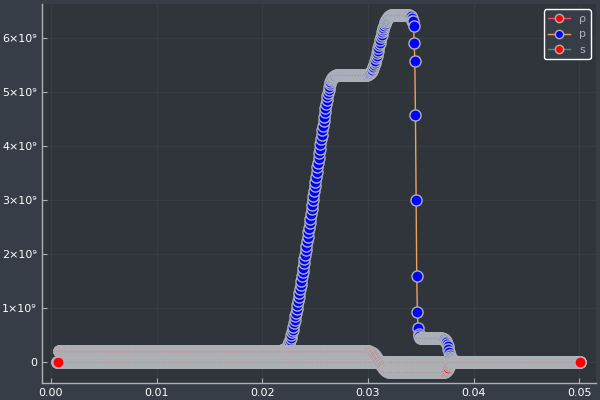

In [242]:
#unicodeplots()
pyplot()
plot(x,uo[:,2:4],#xlims = (0.03,0.035),
    #ylims = (6.4e9,6.5e9),
   # bg = "white",
   # fg = "Black",
    marker = (8,[:red :blue]),label = [ "ρ" "p" "s"])

In [251]:
p = plot(1)
  @gif for x=0:0.1:5
    push!(p, 1, sin(x))
  end

Input #0, image2, from '/tmp/tmpGYwvCz/%06d.png':
  Duration: 00:00:02.04, start: 0.000000, bitrate: N/A
    Stream #0.0: Video: png, bgra, 600x400, 25 fps, 25 tbr, 25 tbn, 25 tbc
Unrecognized option 'vf'


LoadError: failed process: Process(`ffmpeg -v 0 -i /tmp/tmpGYwvCz/%06d.png -vf palettegen=stats_mode=diff -y /tmp/tmpGYwvCz/palette.bmp`, ProcessExited(1)) [1]

In [148]:
Pkg.add("UnicodePlots")

 Resolving package versions...
 Installed UnicodePlots ─ v0.3.1
  Updating `~/.julia/environments/v1.0/Project.toml`
  [b8865327] + UnicodePlots v0.3.1
  Updating `~/.julia/environments/v1.0/Manifest.toml`
  [b8865327] + UnicodePlots v0.3.1


In [252]:
using Plots, ProgressMeter
pyplot(leg=false, ticks=nothing) #change to the pyplot backend and define some defaults
x = y = range(-5, stop = 5, length = 40)
zs = zeros(0,40)
n = 100

# create a progress bar for tracking the animation generation
prog = Progress(n,1)

@gif for i in range(0, stop = 2π, length = n)
    f(x,y) = sin(x + 10sin(i)) + cos(y)

    # create a plot with 3 subplots and a custom layout
    l = @layout [a{0.7w} b; c{0.2h}]
    p = plot(x, y, f, st = [:surface, :contourf], layout=l)

    # induce a slight oscillating camera angle sweep, in degrees (azimuth, altitude)
    plot!(p[1], camera=(15*cos(i), 40))

    # add a tracking line
    fixed_x = zeros(40)
    z = map(f, fixed_x, y)
    plot!(p[1], fixed_x, y, z, line = (:black, 5, 0.2))
    vline!(p[2], [0], line = (:black, 5))

    # add to and show the tracked values over time
    global zs = vcat(zs, z')
    plot!(p[3], zs, alpha = 0.2, palette = cgrad(:blues).colors)

    # increment the progress bar
    next!(prog)
end

LoadError: UndefVarError: warn not defined

In [253]:
using Plots
pyplot()

Plots.PyPlotBackend()

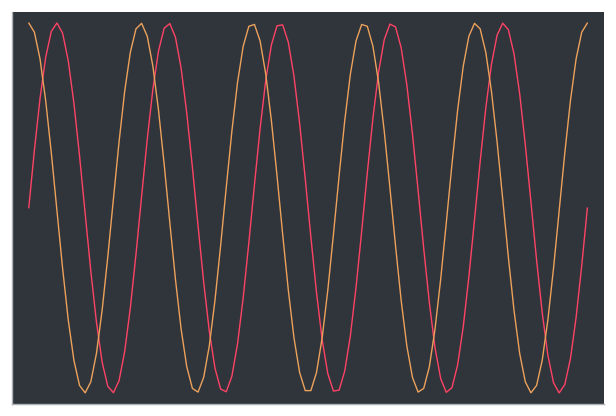

In [257]:
#plot(Plots.fakedata(50, 5), w=3)
p = plot([sin, cos], zeros(0), leg=false)
anim = Animation()
for x = range(0, stop=10π, length=100)
    push!(p, x, Float64[sin(x), cos(x)])
    frame(anim)
end


In [258]:
# define the Lorenz attractor
mutable struct Lorenz
    dt; σ; ρ; β; x; y; z
end

function step!(l::Lorenz)
    dx = l.σ*(l.y - l.x)       ; l.x += l.dt * dx
    dy = l.x*(l.ρ - l.z) - l.y ; l.y += l.dt * dy
    dz = l.x*l.y - l.β*l.z     ; l.z += l.dt * dz
end

attractor = Lorenz((dt = 0.02, σ = 10., ρ = 28., β = 8//3, x = 1., y = 1., z = 1.)...)


# initialize a 3D plot with 1 empty series
plt = plot3d(1, xlim=(-25,25), ylim=(-25,25), zlim=(0,50),
                title = "Lorenz Attractor", marker = 2)

# build an animated gif by pushing new points to the plot, saving every 10th frame
@gif for i=1:1500
    step!(attractor)
    push!(plt, attractor.x, attractor.y, attractor.z)
end every 10

[image2 @ 0x19b6c20]MAX_READ_SIZE:5000000 reached
Input #0, image2, from '/tmp/tmpwLBmEb/%06d.png':
  Duration: 00:00:06.00, start: 0.000000, bitrate: N/A
    Stream #0.0: Video: png, bgra, 600x400, 25 fps, 25 tbr, 25 tbn, 25 tbc
Unrecognized option 'vf'


LoadError: failed process: Process(`ffmpeg -v 0 -i /tmp/tmpwLBmEb/%06d.png -vf palettegen=stats_mode=diff -y /tmp/tmpwLBmEb/palette.bmp`, ProcessExited(1)) [1]